# Лабораторная работа 3: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

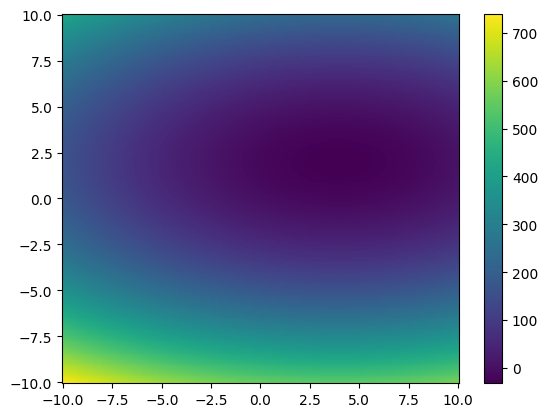

In [1]:
import matplotlib.pyplot as plt # Я захотел красивый график. Вот он.
import matplotlib as mpl
import numpy as np

def f(x, y):
    return -8 * x - 16 * y + x ** 2 + 4 * y ** 2

x = np.linspace(-10, 10, 201)
y = np.linspace(-10, 10, 201)
x1, x2 = np.meshgrid(x, y)
x3 = f(x1, x2)
norm = mpl.colors.Normalize(x3.min(), x3.max())

plt.pcolor(x1, x2, x3, norm=norm)
plt.colorbar()

In [2]:
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp

P = matrix(np.array([[2., 0.],
                     [0., 8.]]))
q = matrix([-8., -16.])
G = matrix((np.array([[1., 1.], 
                      [1., 0.], 
                      [-1., 0.], 
                      [0., -1.]])))
h = matrix([5., 3., 0., 0.])

solver = qp(P, q, G, h)
print(solver['x'])

     pcost       dcost       gap    pres   dres
 0: -3.0512e+01 -3.8829e+01  8e+00  0e+00  2e-01
 1: -3.0792e+01 -3.1146e+01  4e-01  2e-16  5e-03
 2: -3.0982e+01 -3.1024e+01  4e-02  2e-16  4e-04
 3: -3.0997e+01 -3.1003e+01  6e-03  9e-17  4e-17
 4: -3.1000e+01 -3.1000e+01  7e-04  2e-16  5e-18
 5: -3.1000e+01 -3.1000e+01  1e-04  2e-16  3e-17
 6: -3.1000e+01 -3.1000e+01  1e-05  2e-16  3e-17
Optimal solution found.
[ 3.00e+00]
[ 2.00e+00]



**Оптимальное решение:**

In [3]:
solution = solver['x']
solution

<2x1 matrix, tc='d'>

**Проверим, какие аргументы являются активными. Для этого поочерёдно выкинем каждый:**

In [4]:
h1, h2, h3, h4 = h[1:], h[[0, 2, 3]], h[[0, 1, 3]], h[:3]
G1 = matrix(np.array([[1., 0.],  # x1 + x2 <= 5
                      [-1., 0.],
                      [0., -1.]]))
G2 = matrix(np.array([[1., 1.],  # x1 <= 3
                      [-1., 0.],
                      [0., -1.]]))
G3 = matrix(np.array([[1., 1.],  # -x1 <= 0 
                      [1., 0.],
                      [0., -1.]]))  # -x2 <= 0
G4 = matrix(np.array([[1., 1.],
                      [1., 0.],
                      [-1., 0.]]))
hs = [h1, h2, h3, h4]
Gs = [G1, G2, G3, G4]

In [5]:
candidates = []
for i in range(4):
    candidate = qp(P, q, G=Gs[i], h=hs[i])
    candidates.append(candidate['x'])

     pcost       dcost       gap    pres   dres
 0: -3.0240e+01 -3.7371e+01  7e+00  0e+00  2e-01
 1: -3.0901e+01 -3.1124e+01  2e-01  1e-16  5e-03
 2: -3.0999e+01 -3.1001e+01  3e-03  7e-17  6e-05
 3: -3.1000e+01 -3.1000e+01  3e-05  0e+00  6e-07
 4: -3.1000e+01 -3.1000e+01  3e-07  2e-16  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.0419e+01 -3.8120e+01  8e+00  0e+00  2e-16
 1: -3.1027e+01 -3.1339e+01  3e-01  2e-16  4e-17
 2: -3.1196e+01 -3.1201e+01  6e-03  2e-16  2e-17
 3: -3.1200e+01 -3.1200e+01  6e-05  4e-16  2e-17
 4: -3.1200e+01 -3.1200e+01  6e-07  4e-17  4e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.1547e+01 -3.0486e+01  1e+01  5e-01  3e-01
 1: -3.0164e+01 -3.1582e+01  1e+00  4e-17  1e-17
 2: -3.0958e+01 -3.1037e+01  8e-02  2e-16  7e-17
 3: -3.0994e+01 -3.1006e+01  1e-02  2e-16  2e-17
 4: -3.0999e+01 -3.1001e+01  2e-03  0e+00  4e-17
 5: -3.1000e+01 -3.1000e+01  2e-04  2e-16  6e-17
 6: -3.1000e+01 -3.1000e

In [6]:
for i in range(4):
    print('Результат для ограничения номер ', i+1, ':\n', candidates[i], sep='')

Результат для ограничения номер 1:
[ 3.00e+00]
[ 2.00e+00]

Результат для ограничения номер 2:
[ 3.20e+00]
[ 1.80e+00]

Результат для ограничения номер 3:
[ 3.00e+00]
[ 2.00e+00]

Результат для ограничения номер 4:
[ 3.00e+00]
[ 2.00e+00]



**Почти все ограничения не влияют на точку оптимума, то есть не являются активными.**

**Единственное активное ограничение**: $x <= 3$

 ## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

In [7]:
a = np.array([0, 1, 1, 0, 0])
a[np.where(a==0)] = -1
a

array([-1,  1,  1, -1, -1])

In [8]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        M, n = X.shape
        self.weights_ = np.empty(M)
        self.bias_ = 0
        y[np.where(y==0)] = -1
        
        
        self.zeros_ = np.zeros((M, M))
        P = np.diag(np.ones(n + 1))
        P[-1, -1] = 0
        P = np.hstack((P, np.zeros((n + 1, M))))
        P = np.vstack((P, np.zeros((M, M + n + 1))))

        q = np.concatenate((np.zeros(n + 1), np.ones(M) * self.C))
        
        G = np.concatenate(((-y * X.T).T, np.array([-y]).T), axis=1)
        G = np.vstack((G, np.zeros((M, n + 1))))
        self.doble_ones_ = np.vstack((np.diag(-np.ones(M)), np.diag(-np.ones(M))))
        G = np.hstack((G, self.doble_ones_))
        
        h = np.concatenate((-np.ones(M), np.zeros(M)))
        
        P = matrix(P, size=(n + 1 + M, n + 1 + M), tc='d')
        q = matrix(q, tc='d')
        G = matrix(G, size=(2 * M, n + 1 + M), tc='d')
        h = matrix(h, tc='d')
        
        #return P, q, G, h

        solution = np.array(qp(P=P, q=q, G=G, h=h)['x'])
        self.weights_ = solution[:-M-1]
        self.bias_ = solution[n]
        #self.bias_ = np.median(np.dot(self.weights_, X) - y)

        return self.weights_, self.bias_

    
        #self.P_, self.q_, self.G, self.h = P, q, G, h

        
    def predict_proba(self, X):
        return (np.dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return np.sign(self.predict_proba(X))

In [9]:
from sklearn.datasets import make_classification

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [11]:
svm = LinearSVM(10)

In [48]:
def hyperr(x, w, b):
    return (-w[0] * xx - b) / w[1]

     pcost       dcost       gap    pres   dres
 0: -4.8778e+04  2.3343e+04  7e+04  2e+01  5e+01
 1:  7.5352e+02 -1.3726e+03  5e+03  9e-01  2e+00
 2:  2.8049e+02 -2.3519e+02  1e+03  2e-01  4e-01
 3:  1.3569e+02 -6.1343e+01  4e+02  6e-02  2e-01
 4:  1.7902e+02 -4.2180e+01  4e+02  4e-02  1e-01
 5:  6.3428e+01  1.5761e+01  7e+01  6e-03  2e-02
 6:  5.2277e+01  2.1843e+01  3e+01  3e-04  8e-04
 7:  3.8056e+01  2.2816e+01  2e+01  1e-04  3e-04
 8:  3.8630e+01  2.3396e+01  2e+01  1e-04  3e-04
 9:  3.5085e+01  2.6541e+01  9e+00  4e-05  1e-04
10:  3.4659e+01  2.6141e+01  9e+00  4e-05  1e-04
11:  3.4662e+01  2.6167e+01  9e+00  4e-05  1e-04
12:  3.0120e+01  2.7434e+01  3e+00  7e-16  2e-14
13:  2.8798e+01  2.8043e+01  8e-01  4e-16  4e-13
14:  2.8358e+01  2.8349e+01  1e-02  4e-16  1e-13
15:  2.8353e+01  2.8352e+01  1e-04  5e-16  5e-14
16:  2.8352e+01  2.8352e+01  1e-06  5e-16  1e-13
Optimal solution found.


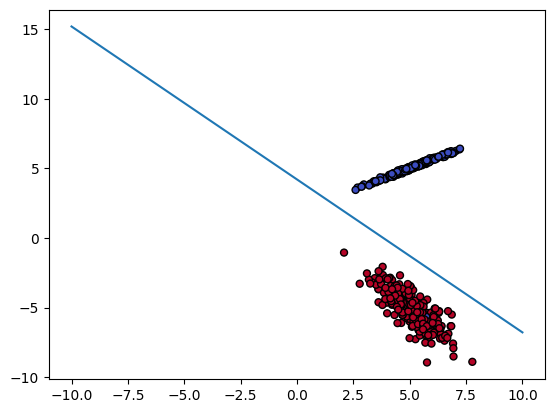

In [51]:
X1, Y1 = make_classification(
    n_samples=500, n_features=2, n_redundant=0, n_clusters_per_class=1, class_sep=5, random_state=42
)

w, b = svm.fit(X1, Y1)
xx = np.linspace(-10, 10, num=300)
yy = hyperr(xx, w, b)

plt.plot(xx, yy)

plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, cmap='coolwarm_r', edgecolor="k");

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

# Примеры

Настройка вывода графиков [`Maplotlib`](http://matplotlib.org/) и импорт функций из модуля [`pylab`](http://wiki.scipy.org/PyLab).

In [14]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Python310\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['norm', 'dot', 'f', 'matrix']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Визуальное решение задачи квадратичного программирования

На следующем рисунке наглядно показано решение задачи QP из задания 1. Оптимизируемая функция $f(\boldsymbol x)$ показана линиями уровня, область значений недопустимых ограничениями окрашена в серый цвет.

C:\Users\user\AppData\Local\Temp\ipykernel_13516\2390794766.py:16: UserWarning: linewidths is ignored by contourf
  contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')


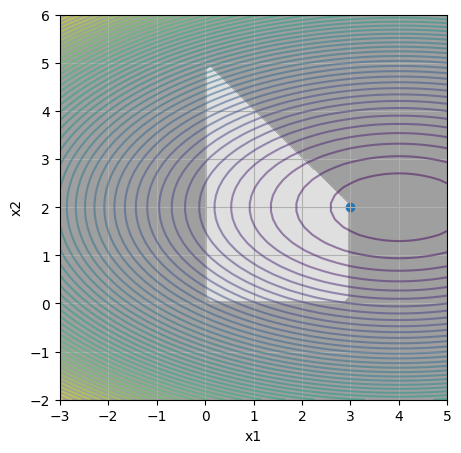

In [15]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

In [16]:
np.array([True, False, False]) & np.array([True, False, True])

array([ True, False, False])

In [17]:
np.logical_and(np.array([True, False, False]), np.array([True, False, True]))

array([ True, False, False])

## Установка и использование `CvxOpt`

Библиотека [`cvxopt`](http://cvxopt.org/) может быть установлена как обычный python-пакет:

In [18]:
!pip install --upgrade --user cvxopt


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [19]:
from cvxopt import solvers
?solvers.qp

Signature:
solvers.qp(
    P,
    q,
    G=None,
    h=None,
    A=None,
    b=None,
    solver=None,
    kktsolver=None,
    initvals=None,
    **kwargs,
)
Docstring:
Solves a quadratic program

    minimize    (1/2)*x'*P*x + q'*x
    subject to  G*x <= h
                A*x = b.


Input arguments.

    P is a n x n dense or sparse 'd' matrix with the lower triangular
    part of P stored in the lower triangle.  Must be positive
    semidefinite.

    q is an n x 1 dense 'd' matrix.

    G is an m x n dense or sparse 'd' matrix.

    h is an m x 1 dense 'd' matrix.

    A is a p x n dense or sparse 'd' matrix.

    b is a p x 1 dense 'd' matrix or None.

    solver is None or 'mosek'.

    The default values for G, h, A and b are empty matrices with
    zero rows.


Output arguments (default solver).

    Returns a dictionary with keys 'status', 'x', 's', 'y', 'z',
    'primal objective', 'dual objective', 'gap', 'relative gap',
    'primal infeasibility, 'dual infeasibility', 'primal

## Пример работы с cvxopt

In [20]:
from cvxopt import matrix

A = matrix([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], (2,3))
print(A)
print(A.size)

[ 1.00e+00  3.00e+00  5.00e+00]
[ 2.00e+00  4.00e+00  6.00e+00]

(2, 3)


In [21]:
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],
            [0.0,-1.0,-3.0,5.0,4.0]])
print(G, G.size)

[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]
[-1.00e+00 -3.00e+00]
[ 2.00e+00  5.00e+00]
[ 3.00e+00  4.00e+00]
 (5, 2)


In [22]:
from cvxopt import solvers

# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])
# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
print(sol['x']) # [7.13e-07, 5.00e+00]
print(sol['primal objective']) # 20.0000061731

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  0e+00  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  1e-16  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  3e-18  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  9e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  1e-16  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  3e-16  7e-17
 6:  2.0062e+01  1.9974e+01  9e-02  9e-17  7e-17
 7:  2.0001e+01  2.0000e+01  9e-04  6e-17  2e-16
 8:  2.0000e+01  2.0000e+01  9e-06  9e-17  4e-16
Optimal solution found.
[ 7.13e-07]
[ 5.00e+00]

20.00000617311241


In [23]:
sol

{'x': <2x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <5x1 matrix, tc='d'>,
 'z': <5x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 8.788553731701755e-06,
 'relative gap': 4.3942774404996174e-07,
 'primal objective': 20.00000617311241,
 'dual objective': 19.99999738455868,
 'primal infeasibility': 8.740420517429097e-17,
 'dual infeasibility': 3.937229820906071e-16,
 'primal slack': 7.131816408857288e-07,
 'dual slack': 1.5069511036049803e-08,
 'iterations': 8}

In [24]:
print(sol['x'])

[ 7.13e-07]
[ 5.00e+00]



Матрицы задач квадратичного программирования как правило разрежены, лучше использовать матричные операции над разреженными матрицами при реализации SVM.
[Разреженные и плотные матрицы](http://abel.ee.ucla.edu/cvxopt/userguide/matrices.html)

## Генерация случайной выборки для задачи классификации

В `SciKit-Learn` есть функция генерации случайных выборок для классификации [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Для того чтобы выборки не менялись при перезапуске ноутбука, используйте параметр `random_state`.

In [25]:
from sklearn.datasets import make_classification

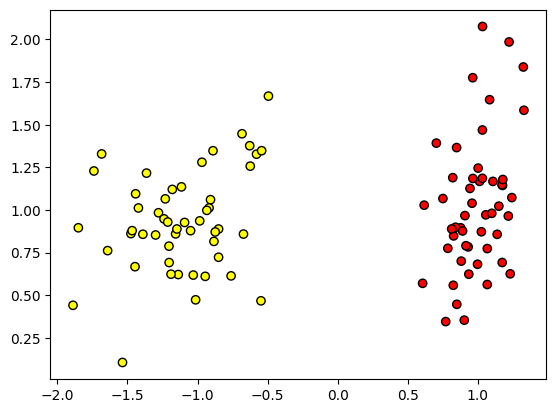

In [26]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

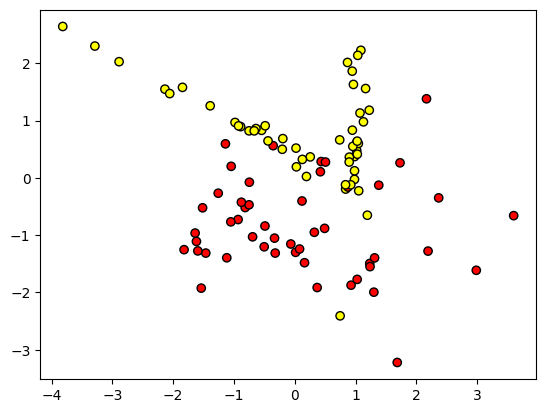

In [27]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

## Визуализация решающего правила

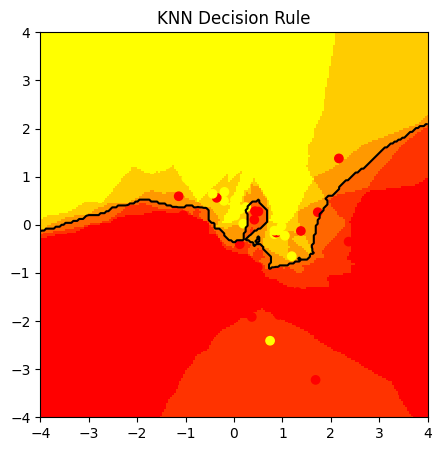

In [28]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

xlim([-4, 4])
ylim([-4, 4])
_ = title('KNN Decision Rule')

## Реализация собственной модели для SciKit-Learn

В заданиях 2 и 3 требуется самостоятельно реализовать алгоритм обучения классификатора. Для того чтобы ваш алгоритм можно было использовать различными компонентами библиотеки SciKit-Learn (оценка качества, подбор параметров, композиции и т.д.) нужно всего лишь [реализовать интерфейс `BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators).

In [29]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        dim = X.shape[1]
        self.weights_ = empty(dim)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        return (dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return sign(self.predict_proba(X))

In [30]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.dim = X.shape[1]
        self.N = X.shape[0]
        self.alpha_ = empty(self.N)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        pass
            
    def predict(self, X):
        pass